In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install torchdiffeq

In [3]:
import numpy as np
import time
import matplotlib.pyplot as plt
from torchdiffeq import odeint
#from torchdiffeq import odeint_adjoint as odeint
import torch
# torch.cuda.current_device()
from torch import nn
from torch import optim
import torch.utils.data as data_utils
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms


In [4]:
from multiprocessing import Process, freeze_support

torch.multiprocessing.set_start_method('spawn', force="True")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])

# rotate an image x given the rotation angle
def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size(),align_corners=False).type(dtype)
    x = F.grid_sample(x, grid,align_corners=False)
    return x

In [6]:
class customTransform(object):
  def __call__(self,img):
    dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
    img = img.view([1,1,28,28]).to(device)
    x = img.repeat(1,16,1,1)
    c = -1
    for theta in np.linspace(0,np.pi*2,16):
      c+=1
      x[0,c,:,:] = rot_img(img, theta, dtype)
    x = x.permute([1,0,2,3])
    return  x

In [7]:
TF = transforms.Compose([
      transforms.ToTensor(),
      customTransform()
    ])  

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=TF
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=TF
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


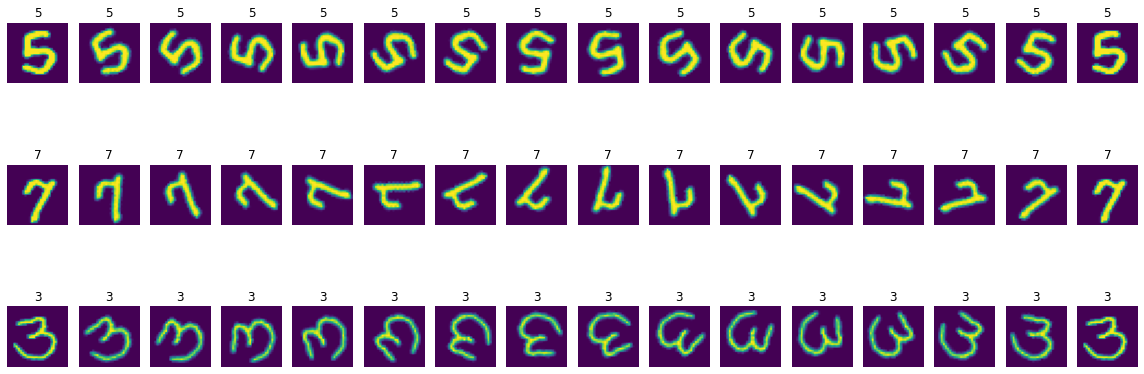

In [8]:
figure = plt.figure(figsize=(16,8))
cols, rows = 16, 3
c = 0
for i in range(0,rows):
  sample_idx = torch.randint(len(training_data),size=(1,)).item()
  img, label = training_data[sample_idx]
  for j in range(0,cols):
     c += 1
     figure.add_subplot(rows, cols, c)
     plt.title(label)
     plt.axis("off")
     plt.imshow(img[j,0].cpu().squeeze())
  plt.tight_layout()


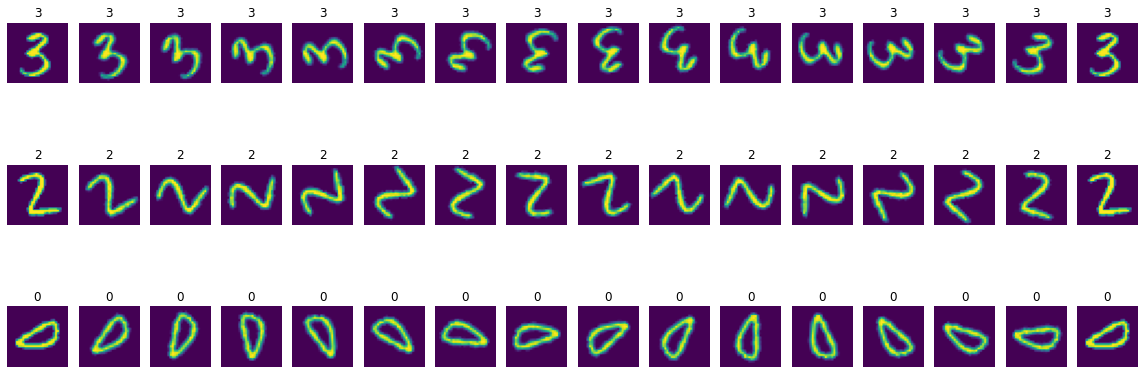

In [9]:
figure = plt.figure(figsize=(16,8))
cols, rows = 16, 3
c = 0
for i in range(0,rows):
  sample_idx = torch.randint(len(test_data),size=(1,)).item()
  img, label = test_data[sample_idx]
  for j in range(0,cols):
     c += 1
     figure.add_subplot(rows, cols, c)
     plt.title(label)
     plt.axis("off")
     plt.imshow(img[j,0].cpu().squeeze())
  plt.tight_layout()


In [10]:
img.shape

torch.Size([16, 1, 28, 28])

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


0


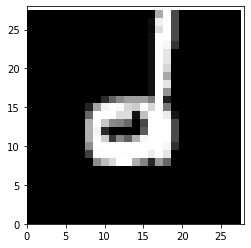

In [29]:
from matplotlib import rc
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
rc('animation', html='jshtml')
fig = plt.figure() 
ax = plt.axes(xlim=(0, 28), ylim=(0, 28)) 
def frame(w):
  print(w)

  #ax.clear()
  #w=w+1
  #print(w)
  img, label = test_data[6000]
  pixels = img[w,:].reshape((28, 28))
  plot=ax.imshow(pixels.cpu(), cmap='gray')
  #w=w+1
    #global x,y,z
    #x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
    #y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
    #z=z+np.random.normal(loc=0.0,scale=50.0,size=10)



    
  return plot

anim = animation.FuncAnimation(fig, frame, frames=16, blit=False, repeat=True)
anim

In [168]:
class BaseODE2VAE(nn.Module):
  def __init__(self):
    super(BaseODE2VAE,self).__init__()

    self.aug_enc = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2, bias=False),
      nn.BatchNorm2d(32),
      nn.ELU(),
      nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(32),
      nn.ELU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
      nn.BatchNorm2d(64),
      nn.ELU(),
      nn.Conv2d(64, 16, kernel_size=5, stride=1, padding=2, bias=True),
      nn.Flatten()
    )

    # q(s0|x0) mean
    self.q_s0x0_mean = nn.Sequential(
        nn.Linear(784,64),
        nn.ReLU(True),
        nn.Linear(64,32)
    )

    # q(s0|x0) logvar
    self.q_s0x0_logvar = nn.Sequential(
        nn.Linear(784,64),
        nn.ReLU(True),
        nn.Linear(64,32)
    )

     # q(v0|x0) mean
    self.q_v0x0_mean = nn.Sequential(
        nn.Linear(784,64),
        nn.ReLU(True),
        nn.Linear(64,32)
    )

    # q(v0|x0) logvar
    self.q_v0x0_logvar = nn.Sequential(
        nn.Linear(784,64),
        nn.ReLU(True),
        nn.Linear(64,32)
    )

    # q(a|s,v) mean
    self.q_az_mean = nn.Sequential(
        nn.Linear(64,64),
        nn.BatchNorm1d(64),
        nn.ELU(True),
        nn.Linear(64,32)
    )

    # q(a|s,v) logvar
    self.q_az_logvar = nn.Sequential(
        nn.Linear(64,64),
        nn.BatchNorm1d(64),
        nn.ELU(True),
        nn.Linear(64,32)
    )

    # p(x|s)
    self.p_xs_bernoulli = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(True),
        nn.Linear(64, 784),
        nn.ReLU(True),
        nn.Unflatten(1,(16,7,7)),
        nn.ConvTranspose2d(16, 32, kernel_size=4, stride=1, padding=2, output_padding=0, bias=False),
        nn.BatchNorm2d(32),
        nn.ELU(),
        nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=1,  output_padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.ELU(),
        nn.ConvTranspose2d(16, 16, kernel_size=5, stride=2, padding=2,  output_padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.ELU(),
        nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1,  output_padding=0, bias=True),
        nn.Sigmoid()
    )

    self.mvn = torch.distributions.MultivariateNormal(torch.zeros(32).to(device), torch.eye(32).to(device))

    # augmented encoder
  def aug_encoder(self, x):
    z_aug = self.aug_enc(x)
    return z_aug

  # q(s0|x0)
  def q_s0(self, z_aug):
    q_s0x0_mean = self.q_s0x0_mean(z_aug)
    q_s0x0_logvar = self.q_s0x0_logvar(z_aug)
    return q_s0x0_mean, q_s0x0_logvar
  
  # q(v0|x0)
  def q_v0(self, z_aug):
    q_v0x0_mean = self.q_v0x0_mean(z_aug)
    q_v0x0_logvar = self.q_v0x0_logvar(z_aug)
    return q_v0x0_mean, q_v0x0_logvar

  # q(a|z)
  def q_asv(self, z):
    s, v = z
    z = torch.cat([s,v],1)
    a_mean = self.q_az_mean(z)
    a_logvar = self.q_az_logvar(z)
    return a_mean, a_logvar

  # p(x0|s0)
  def p_xs(self, z_s):
    p_xs = self.p_xs_bernoulli(z_s)
    return p_xs

  def reparameterize(self, mean, logvar, L=torch.FloatTensor([])):
      if mean.size()[0] == 0:
          return torch.FloatTensor([])
      std = torch.exp(0.5 * logvar)
      eps = torch.randn_like(std)
      logp = self.mvn.log_prob(eps)
      if L.size()[0] == 0:
          return mean + eps * std, logp
      else:
          return mean + torch.matmul(L, eps.view([-1, mean.size()[-1], 1])).view([mean.size()]) + std * eps, logp

  def ode2vae_rhs(self,t,z,f):
      s, v, logp = z
      q = s.shape[1]
      a, _ = f((s,v))
      dfdv = torch.stack(
                  [torch.autograd.grad(a[:,i],v,torch.ones_like(a[:,i]),
                  retain_graph=True,create_graph=True)[0].contiguous()[:,i]
                  for i in range(q)],1)
      tr_dfdv = torch.sum(dfdv,1)
      return (v, a, -tr_dfdv)

  def forward(self, x):
    x0 = x[:,0]
    # agumented features of x0
    z_aug = self.aug_encoder(x0)

    # latent position
    z_q_s0x0_mean, z_q_s0x0_logvar = self.q_s0(z_aug)
    z_s0, logp_s0 = self.reparameterize(z_q_s0x0_mean, z_q_s0x0_logvar)

    # latent velocity
    z_q_v0x0_mean, z_q_v0x0_logvar = self.q_v0(z_aug)
    z_v0, logp_v0 = self.reparameterize(z_q_v0x0_mean, z_q_v0x0_logvar)

    # logprob
    logp0 = logp_s0*logp_v0

    # latent vector
    z0 = (z_s0, z_v0)

    # ODE
    t  = 0.1 * torch.arange(16,dtype=torch.float).to(z_s0.device)
    ztL   = []
    logpL = []
    oderhs = lambda t, h: self.ode2vae_rhs(t, h, self.q_asv) 
    zt, vt, logp = odeint(oderhs, (z_s0, z_v0, logp0), t, method="fehlberg2", rtol=0.1)
    logp = logp.permute([1,0])
    zt = zt.permute([1,0,2])
    zt = zt.contiguous().view([50*16, 32])
    #zt = zt.contiguous().view([2*16, 32])

    # decoder
    p_xs = self.p_xs(zt)
    xh = p_xs.view([50,16,1,28,28])
    #xh = p_xs.view([2,16,1,28,28])


    return z_q_s0x0_mean, z_q_s0x0_logvar, z_s0, zt, logp, p_xs, xh
  








In [169]:
class TrainBaseODE2VAE():
  def __init__(self, model, train_loader, test_loader, device):
    self.model = model
    self.device = device
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.batch_size = 50
    self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
    self.epochs = 2
    # self.batch_count = len(train_loader.dataset.data) // self.batch_size
    self.losses = {
        'train_elbo': [],
        'test_elbo': [],
        'train_klz': [],
        'test_klz': [],
        'train_lhood': [],
        'test_lhood': [],
    }
    self.sample = {
        'train': {
          'x': None,
          'xh': None      
        },
        'test': {
          'x': None,
          'xh': None      
        }
    }
    self.mvn = torch.distributions.MultivariateNormal(torch.zeros(32).to(device), torch.eye(32).to(device))
  
  # def update_optimizer(self, lr):
  #     self.optimizer = optim.Adam(model.parameters(), lr=lr)

  # def bernoulli_likelihood(self, x_hat, x):
  #     BCE = nn.BCELoss()
  #     # BCE = nn.MSELoss()
  #     loss = BCE(x_hat.view(-1,28*28),x.view(-1,28*28))
  #     return loss

  # # check this... monte carlo KL divergence not converging
  # def kl_divergence(self, z, mean, logvar):
  #     std = torch.exp(logvar / 2)

  #     # Monte carlo KL divergence
  #     p = torch.distributions.Normal(torch.zeros_like(mean), torch.ones_like(std))
  #     q = torch.distributions.Normal(mean, std)

  #     # get the probabilities from the equation
  #     log_qzx = q.log_prob(z)
  #     log_pz = p.log_prob(z)

  #     # kl
  #     kl = (log_qzx - log_pz)
  #     return kl.sum()

  def calc_elbo(self, zt, logp, x, xh):
    log_pzt = self.mvn.log_prob(zt.contiguous())
    log_pzt = log_pzt.view([self.batch_size,16])

    klzt = logp - log_pzt
    klz = klzt.sum(1).mean(0)

    lhood = torch.log(1e-3+xh)*x + torch.log(1e-3+1-xh)*(1-x)
    lhood = lhood.sum()

    elbo = lhood - klz

    return elbo, lhood, klz
    
  # check this... monte carlo KL divergence not converging
  def calc_loss(self, x, mode='train'):
    z_q_s0x0_mean, z_q_s0x0_logvar, z_s0, zt, logp, p_xs, xh = self.model(x)
    elbo, lhood, klz = self.calc_elbo(zt, logp, x, xh)
    # # reconstruction loss
    # recon_loss = self.bernoulli_likelihood(x_hat=xh, x=x)

    # # kl
    # # kl = self.kl_divergence(z=z_s0, mean=z_q_s0x0_mean, logvar=z_q_s0x0_logvar)
    # kl = -0.5 * torch.sum(1 + z_q_s0x0_logvar - z_q_s0x0_mean.pow(2) - z_q_s0x0_logvar.exp())
    # kl /= self.batch_size * 784

    # elbo
    # elbo = (kl + recon_loss)

    if mode == 'train':
      self.sample['train']['x'] = x.clone().cpu().detach()
      self.sample['train']['xh'] = xh.clone().cpu().detach()
      self.losses['train_elbo'].append(elbo.item())
      self.losses['train_klz'].append(klz.item())
      self.losses['train_lhood'].append(lhood.item())
    elif mode == 'test':
      self.sample['test']['x'] = x.clone().cpu().detach()
      self.sample['test']['xh'] = xh.clone().cpu().detach()
      self.losses['test_elbo'].append(elbo.item())
      self.losses['test_klz'].append(klz.item())
      self.losses['test_lhood'].append(lhood.item())

    return elbo, lhood, klz

  def train(self):
    for epoch in range(self.epochs):
      # self.update_optimizer(lr=1e-2*0.9**(epoch+1))
      self.optimizer.zero_grad()
      st = time.time()
      for batch_idx, data in enumerate(self.train_loader):
          sst = time.time()
          x, label = data
          elbo, lhood, klz = self.calc_loss(x.to(device), 'train')
          tr_loss = -elbo
          tr_loss.backward(retain_graph=True)
          self.optimizer.step()
          self.optimizer.zero_grad()
          eet = time.time()
          print('     Train BatchId: {:.2f}. Took: {:.2f} seconds.'.format(batch_idx, eet-sst))
      # with torch.no_grad():
      for batch_idx, data in enumerate(self.test_loader): 
        x, label = data
        elbo, lhood, klz = self.calc_loss(x.to(device), 'test')
        print('     Test BatchId: {:.2f}.'.format(batch_idx))
      et = time.time()
      print('EPOCH {}. Took {:.2f}. Test Loss {:.4f}. Train Loss {:.4f}.'.format(epoch, et-st, np.mean(self.losses['test_elbo'][-100:]), np.mean(self.losses['train_elbo'][-100:])))
      self.plot_sample()
  
  def plot_loss(self):
    plt.figure(figsize=(8,12))
    plt.plot(self.losses['train_elbo'], label='train elbo')
    plt.plot(self.losses['test_elbo'], label='test elbo')
    plt.legend()
    plt.show()

  def plot_sample(self):
    fig, ax = plt.subplots(8,8,figsize=(10,5))
    for i in range(4):
      for j in range(8):
        ax[2*i,j].imshow(self.sample['train']['x'][i,j,0])
        ax[2*i+1,j].imshow(self.sample['train']['xh'][i,j,0])
    plt.show()

In [170]:
batch_size = 50
mask_train = torch.where(training_data.targets==3)[0][0:6000]
mask_test = torch.where(test_data.targets==3)[0][0:1000]
trainsubset = torch.utils.data.Subset(training_data, mask_train)
testsubset = torch.utils.data.Subset(test_data, mask_test)
train_loader = data_utils.DataLoader(dataset = trainsubset, batch_size = batch_size, shuffle = True, num_workers=0)
test_loader = data_utils.DataLoader(dataset = testsubset, batch_size = batch_size, shuffle = True, num_workers=0)

In [151]:
model=BaseODE2VAE().to(device)
TRAIN = TrainBaseODE2VAE(model, train_loader, test_loader, device)

     Train BatchId: 0.00. Took: 0.36 seconds.
     Train BatchId: 1.00. Took: 0.35 seconds.
     Train BatchId: 2.00. Took: 0.34 seconds.
     Train BatchId: 3.00. Took: 0.32 seconds.
     Train BatchId: 4.00. Took: 0.41 seconds.
     Train BatchId: 5.00. Took: 0.35 seconds.
     Train BatchId: 6.00. Took: 0.41 seconds.
     Train BatchId: 7.00. Took: 0.34 seconds.
     Train BatchId: 8.00. Took: 0.34 seconds.
     Train BatchId: 9.00. Took: 0.34 seconds.
     Train BatchId: 10.00. Took: 0.35 seconds.
     Train BatchId: 11.00. Took: 0.38 seconds.
     Train BatchId: 12.00. Took: 0.37 seconds.
     Train BatchId: 13.00. Took: 0.35 seconds.
     Train BatchId: 14.00. Took: 0.36 seconds.
     Train BatchId: 15.00. Took: 0.35 seconds.
     Train BatchId: 16.00. Took: 0.37 seconds.
     Train BatchId: 17.00. Took: 0.36 seconds.
     Train BatchId: 18.00. Took: 0.34 seconds.
     Train BatchId: 19.00. Took: 0.37 seconds.
     Train BatchId: 20.00. Took: 0.34 seconds.
     Train BatchId: 21.

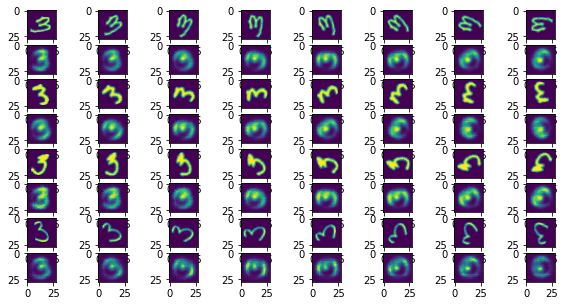

     Train BatchId: 0.00. Took: 0.33 seconds.
     Train BatchId: 1.00. Took: 0.33 seconds.
     Train BatchId: 2.00. Took: 0.36 seconds.
     Train BatchId: 3.00. Took: 0.36 seconds.
     Train BatchId: 4.00. Took: 0.34 seconds.
     Train BatchId: 5.00. Took: 0.29 seconds.
     Train BatchId: 6.00. Took: 0.28 seconds.
     Train BatchId: 7.00. Took: 0.27 seconds.
     Train BatchId: 8.00. Took: 0.30 seconds.
     Train BatchId: 9.00. Took: 0.28 seconds.
     Train BatchId: 10.00. Took: 0.28 seconds.
     Train BatchId: 11.00. Took: 0.29 seconds.
     Train BatchId: 12.00. Took: 0.28 seconds.
     Train BatchId: 13.00. Took: 0.27 seconds.
     Train BatchId: 14.00. Took: 0.27 seconds.
     Train BatchId: 15.00. Took: 0.27 seconds.
     Train BatchId: 16.00. Took: 0.29 seconds.
     Train BatchId: 17.00. Took: 0.26 seconds.
     Train BatchId: 18.00. Took: 0.26 seconds.
     Train BatchId: 19.00. Took: 0.28 seconds.
     Train BatchId: 20.00. Took: 0.29 seconds.
     Train BatchId: 21.

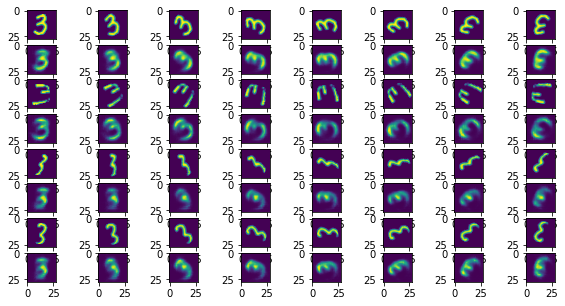

     Train BatchId: 0.00. Took: 0.35 seconds.
     Train BatchId: 1.00. Took: 0.34 seconds.
     Train BatchId: 2.00. Took: 0.36 seconds.
     Train BatchId: 3.00. Took: 0.36 seconds.
     Train BatchId: 4.00. Took: 0.34 seconds.
     Train BatchId: 5.00. Took: 0.34 seconds.
     Train BatchId: 6.00. Took: 0.27 seconds.
     Train BatchId: 7.00. Took: 0.35 seconds.
     Train BatchId: 8.00. Took: 0.33 seconds.
     Train BatchId: 9.00. Took: 0.33 seconds.
     Train BatchId: 10.00. Took: 0.32 seconds.
     Train BatchId: 11.00. Took: 0.33 seconds.
     Train BatchId: 12.00. Took: 0.29 seconds.
     Train BatchId: 13.00. Took: 0.33 seconds.
     Train BatchId: 14.00. Took: 0.37 seconds.
     Train BatchId: 15.00. Took: 0.38 seconds.
     Train BatchId: 16.00. Took: 0.36 seconds.
     Train BatchId: 17.00. Took: 0.33 seconds.
     Train BatchId: 18.00. Took: 0.27 seconds.
     Train BatchId: 19.00. Took: 0.35 seconds.
     Train BatchId: 20.00. Took: 0.34 seconds.
     Train BatchId: 21.

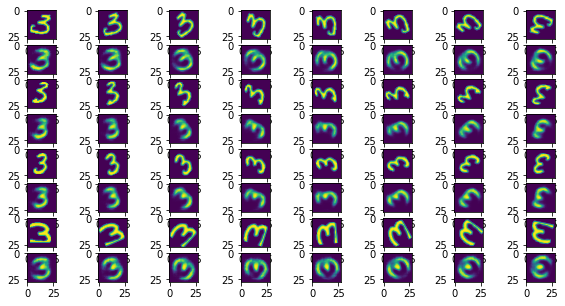

     Train BatchId: 0.00. Took: 0.28 seconds.
     Train BatchId: 1.00. Took: 0.28 seconds.
     Train BatchId: 2.00. Took: 0.30 seconds.
     Train BatchId: 3.00. Took: 0.28 seconds.
     Train BatchId: 4.00. Took: 0.29 seconds.
     Train BatchId: 5.00. Took: 0.28 seconds.
     Train BatchId: 6.00. Took: 0.28 seconds.
     Train BatchId: 7.00. Took: 0.28 seconds.
     Train BatchId: 8.00. Took: 0.28 seconds.
     Train BatchId: 9.00. Took: 0.27 seconds.
     Train BatchId: 10.00. Took: 0.33 seconds.
     Train BatchId: 11.00. Took: 0.28 seconds.
     Train BatchId: 12.00. Took: 0.28 seconds.
     Train BatchId: 13.00. Took: 0.28 seconds.
     Train BatchId: 14.00. Took: 0.34 seconds.
     Train BatchId: 15.00. Took: 0.27 seconds.
     Train BatchId: 16.00. Took: 0.26 seconds.
     Train BatchId: 17.00. Took: 0.27 seconds.
     Train BatchId: 18.00. Took: 0.28 seconds.
     Train BatchId: 19.00. Took: 0.33 seconds.
     Train BatchId: 20.00. Took: 0.34 seconds.
     Train BatchId: 21.

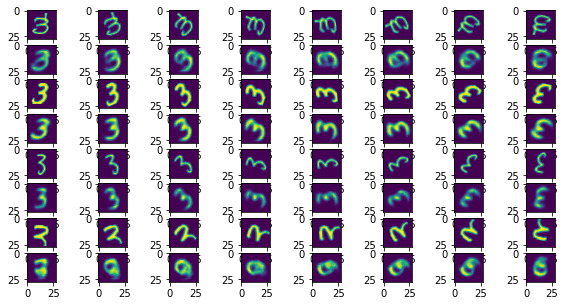

     Train BatchId: 0.00. Took: 0.27 seconds.
     Train BatchId: 1.00. Took: 0.34 seconds.
     Train BatchId: 2.00. Took: 0.28 seconds.
     Train BatchId: 3.00. Took: 0.28 seconds.
     Train BatchId: 4.00. Took: 0.29 seconds.
     Train BatchId: 5.00. Took: 0.27 seconds.
     Train BatchId: 6.00. Took: 0.28 seconds.
     Train BatchId: 7.00. Took: 0.33 seconds.
     Train BatchId: 8.00. Took: 0.27 seconds.
     Train BatchId: 9.00. Took: 0.26 seconds.
     Train BatchId: 10.00. Took: 0.27 seconds.
     Train BatchId: 11.00. Took: 0.34 seconds.
     Train BatchId: 12.00. Took: 0.27 seconds.
     Train BatchId: 13.00. Took: 0.34 seconds.
     Train BatchId: 14.00. Took: 0.35 seconds.
     Train BatchId: 15.00. Took: 0.34 seconds.
     Train BatchId: 16.00. Took: 0.35 seconds.
     Train BatchId: 17.00. Took: 0.37 seconds.
     Train BatchId: 18.00. Took: 0.34 seconds.
     Train BatchId: 19.00. Took: 0.27 seconds.
     Train BatchId: 20.00. Took: 0.35 seconds.
     Train BatchId: 21.

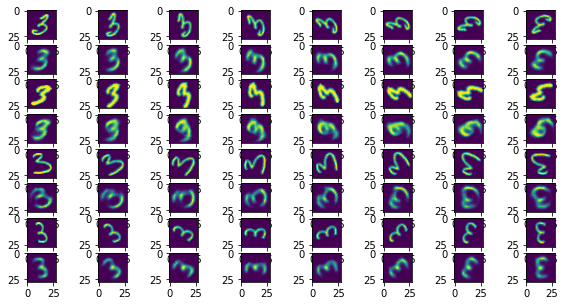

     Train BatchId: 0.00. Took: 0.33 seconds.
     Train BatchId: 1.00. Took: 0.27 seconds.
     Train BatchId: 2.00. Took: 0.35 seconds.
     Train BatchId: 3.00. Took: 0.35 seconds.
     Train BatchId: 4.00. Took: 0.35 seconds.
     Train BatchId: 5.00. Took: 0.34 seconds.
     Train BatchId: 6.00. Took: 0.34 seconds.
     Train BatchId: 7.00. Took: 0.27 seconds.
     Train BatchId: 8.00. Took: 0.33 seconds.
     Train BatchId: 9.00. Took: 0.34 seconds.
     Train BatchId: 10.00. Took: 0.27 seconds.
     Train BatchId: 11.00. Took: 0.27 seconds.
     Train BatchId: 12.00. Took: 0.27 seconds.
     Train BatchId: 13.00. Took: 0.26 seconds.
     Train BatchId: 14.00. Took: 0.35 seconds.
     Train BatchId: 15.00. Took: 0.34 seconds.
     Train BatchId: 16.00. Took: 0.26 seconds.
     Train BatchId: 17.00. Took: 0.29 seconds.
     Train BatchId: 18.00. Took: 0.36 seconds.
     Train BatchId: 19.00. Took: 0.30 seconds.
     Train BatchId: 20.00. Took: 0.29 seconds.
     Train BatchId: 21.

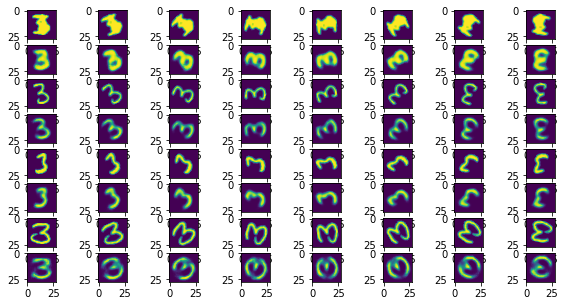

     Train BatchId: 0.00. Took: 0.34 seconds.
     Train BatchId: 1.00. Took: 0.27 seconds.
     Train BatchId: 2.00. Took: 0.29 seconds.
     Train BatchId: 3.00. Took: 0.35 seconds.
     Train BatchId: 4.00. Took: 0.28 seconds.
     Train BatchId: 5.00. Took: 0.28 seconds.
     Train BatchId: 6.00. Took: 0.26 seconds.
     Train BatchId: 7.00. Took: 0.36 seconds.
     Train BatchId: 8.00. Took: 0.28 seconds.
     Train BatchId: 9.00. Took: 0.34 seconds.
     Train BatchId: 10.00. Took: 0.29 seconds.
     Train BatchId: 11.00. Took: 0.28 seconds.
     Train BatchId: 12.00. Took: 0.34 seconds.
     Train BatchId: 13.00. Took: 0.33 seconds.
     Train BatchId: 14.00. Took: 0.35 seconds.
     Train BatchId: 15.00. Took: 0.26 seconds.
     Train BatchId: 16.00. Took: 0.26 seconds.
     Train BatchId: 17.00. Took: 0.34 seconds.
     Train BatchId: 18.00. Took: 0.29 seconds.
     Train BatchId: 19.00. Took: 0.27 seconds.
     Train BatchId: 20.00. Took: 0.28 seconds.
     Train BatchId: 21.

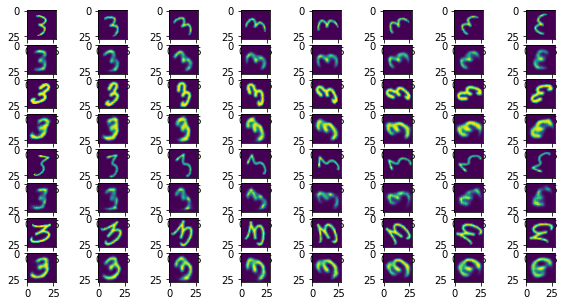

     Train BatchId: 0.00. Took: 0.28 seconds.
     Train BatchId: 1.00. Took: 0.27 seconds.
     Train BatchId: 2.00. Took: 0.35 seconds.
     Train BatchId: 3.00. Took: 0.37 seconds.
     Train BatchId: 4.00. Took: 0.27 seconds.
     Train BatchId: 5.00. Took: 0.32 seconds.
     Train BatchId: 6.00. Took: 0.35 seconds.
     Train BatchId: 7.00. Took: 0.27 seconds.
     Train BatchId: 8.00. Took: 0.36 seconds.
     Train BatchId: 9.00. Took: 0.37 seconds.
     Train BatchId: 10.00. Took: 0.34 seconds.
     Train BatchId: 11.00. Took: 0.27 seconds.
     Train BatchId: 12.00. Took: 0.35 seconds.
     Train BatchId: 13.00. Took: 0.28 seconds.
     Train BatchId: 14.00. Took: 0.35 seconds.
     Train BatchId: 15.00. Took: 0.34 seconds.
     Train BatchId: 16.00. Took: 0.40 seconds.
     Train BatchId: 17.00. Took: 0.34 seconds.
     Train BatchId: 18.00. Took: 0.26 seconds.
     Train BatchId: 19.00. Took: 0.35 seconds.
     Train BatchId: 20.00. Took: 0.26 seconds.
     Train BatchId: 21.

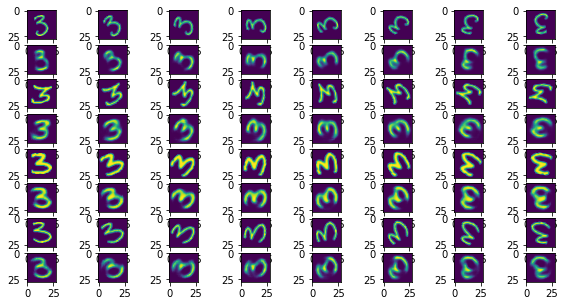

     Train BatchId: 0.00. Took: 0.35 seconds.
     Train BatchId: 1.00. Took: 0.33 seconds.
     Train BatchId: 2.00. Took: 0.41 seconds.
     Train BatchId: 3.00. Took: 0.35 seconds.
     Train BatchId: 4.00. Took: 0.34 seconds.
     Train BatchId: 5.00. Took: 0.36 seconds.
     Train BatchId: 6.00. Took: 0.35 seconds.
     Train BatchId: 7.00. Took: 0.34 seconds.
     Train BatchId: 8.00. Took: 0.35 seconds.
     Train BatchId: 9.00. Took: 0.35 seconds.
     Train BatchId: 10.00. Took: 0.33 seconds.
     Train BatchId: 11.00. Took: 0.36 seconds.
     Train BatchId: 12.00. Took: 0.36 seconds.
     Train BatchId: 13.00. Took: 0.37 seconds.
     Train BatchId: 14.00. Took: 0.35 seconds.
     Train BatchId: 15.00. Took: 0.35 seconds.
     Train BatchId: 16.00. Took: 0.33 seconds.
     Train BatchId: 17.00. Took: 0.36 seconds.
     Train BatchId: 18.00. Took: 0.36 seconds.
     Train BatchId: 19.00. Took: 0.36 seconds.
     Train BatchId: 20.00. Took: 0.36 seconds.
     Train BatchId: 21.

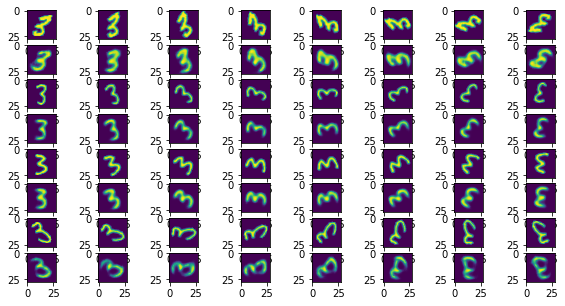

     Train BatchId: 0.00. Took: 0.37 seconds.
     Train BatchId: 1.00. Took: 0.27 seconds.
     Train BatchId: 2.00. Took: 0.26 seconds.
     Train BatchId: 3.00. Took: 0.28 seconds.
     Train BatchId: 4.00. Took: 0.34 seconds.
     Train BatchId: 5.00. Took: 0.28 seconds.
     Train BatchId: 6.00. Took: 0.39 seconds.
     Train BatchId: 7.00. Took: 0.26 seconds.
     Train BatchId: 8.00. Took: 0.34 seconds.
     Train BatchId: 9.00. Took: 0.27 seconds.
     Train BatchId: 10.00. Took: 0.29 seconds.
     Train BatchId: 11.00. Took: 0.33 seconds.
     Train BatchId: 12.00. Took: 0.33 seconds.
     Train BatchId: 13.00. Took: 0.37 seconds.
     Train BatchId: 14.00. Took: 0.37 seconds.
     Train BatchId: 15.00. Took: 0.30 seconds.
     Train BatchId: 16.00. Took: 0.36 seconds.
     Train BatchId: 17.00. Took: 0.28 seconds.
     Train BatchId: 18.00. Took: 0.37 seconds.
     Train BatchId: 19.00. Took: 0.36 seconds.
     Train BatchId: 20.00. Took: 0.42 seconds.
     Train BatchId: 21.

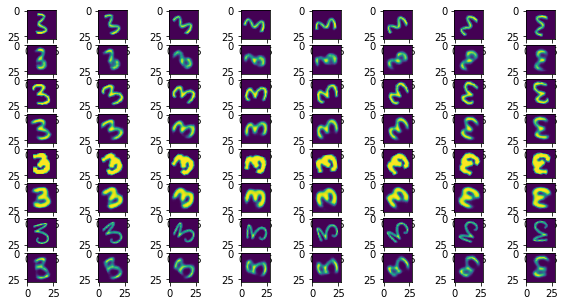

In [152]:
TRAIN.epochs=10
TRAIN.train()

In [171]:
batch_size = 50
mask_train = torch.where(training_data.targets==3)[0][0:6000]
mask_test = torch.where(test_data.targets==3)[0][0:1000]
trainsubset = torch.utils.data.Subset(training_data, mask_train)
testsubset = torch.utils.data.Subset(test_data, mask_test)
train_loader = data_utils.DataLoader(dataset = trainsubset, batch_size = batch_size, shuffle = True, num_workers=0)
test_loader = data_utils.DataLoader(dataset = testsubset, batch_size = batch_size, shuffle = True, num_workers=0)

In [172]:
len(test_loader)

20

In [173]:

it = iter(test_loader)
first = next(it)
z_q_s0x0_mean, z_q_s0x0_logvar, z_s0, zt, logp, p_xs, xh=model.forward(first[0])

In [175]:
first[0].shape

torch.Size([50, 16, 1, 28, 28])

In [174]:
xh.shape

torch.Size([50, 16, 1, 28, 28])

In [182]:
zt.shape

torch.Size([800, 32])

In [184]:
logp.shape

torch.Size([50, 16])

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


0


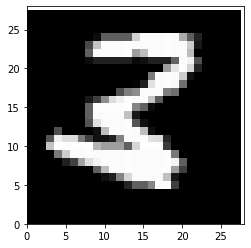

In [187]:
from matplotlib import rc
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
rc('animation', html='jshtml')
fig = plt.figure() 
ax = plt.axes(xlim=(0, 28), ylim=(0, 28)) 
def frame(w):
  print(w)

  #ax.clear()
  #w=w+1
  #print(w)
  #img= test_loader.dataset[999][0]
  pixels = first[0][30][w].reshape((28, 28))
  plot=ax.imshow(pixels.cpu(), cmap='gray')
  #w=w+1
    #global x,y,z
    #x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
    #y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
    #z=z+np.random.normal(loc=0.0,scale=50.0,size=10)



    
  return plot

anim = animation.FuncAnimation(fig, frame, frames=16, blit=False, repeat=True)
anim

In [97]:
first[0][0][0].shape

torch.Size([1, 28, 28])

In [105]:
xh[0][0][0].shape

torch.Size([28, 28])

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


0


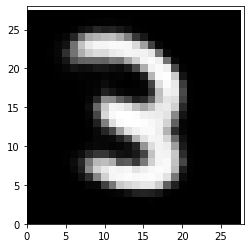

In [189]:
from matplotlib import rc
from math import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import matplotlib.animation as animation
rc('animation', html='jshtml')
fig = plt.figure() 
ax = plt.axes(xlim=(0, 28), ylim=(0, 28)) 
def frame(w):
  print(w)

  #ax.clear()
  #w=w+1
  #print(w)
  #img= test_loader.dataset[999][0]
  pixels = xh[35][w].reshape((28, 28))
  plot=ax.imshow(pixels.cpu().detach().numpy(), cmap='gray')
  #w=w+1
    #global x,y,z
    #x=x+np.random.normal(loc=0.0,scale=50.0,size=10)
    #y=y+np.random.normal(loc=0.0,scale=50.0,size=10)
    #z=z+np.random.normal(loc=0.0,scale=50.0,size=10)



    
  return plot

anim = animation.FuncAnimation(fig, frame, frames=16, blit=False, repeat=True)
anim

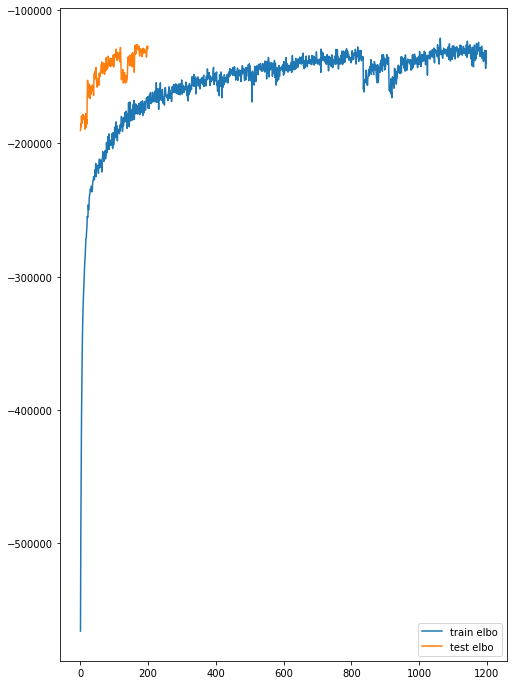

In [179]:
plt.figure(figsize=(8,12))
plt.plot(TRAIN.losses['train_k'], label='train elbo')
plt.plot(TRAIN.losses['test_elbo'], label='test elbo')
plt.legend()

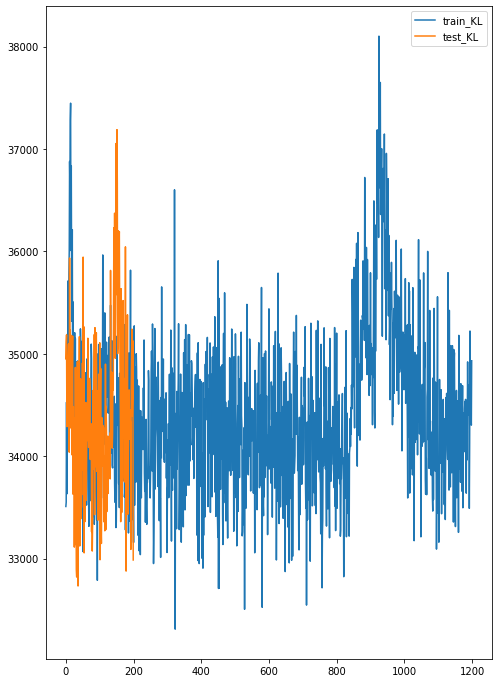

In [180]:
plt.figure(figsize=(8,12))
plt.plot(TRAIN.losses['train_klz'], label='train_KL')
plt.plot(TRAIN.losses['test_klz'], label='test_KL')
plt.legend()  

In [45]:
ls

raw/


bin/      datalab/  home/   lib64/  opt/   run/   sys/                tools/
boot/     dev/      lib/    media/  proc/  sbin/  tensorflow-1.15.2/  usr/
content/  etc/      lib32/  mnt/    root/  srv/   tmp/                var/


In [50]:
cd usr/

/usr


In [51]:
ls

bin/    grte/     lib/    lib64-nvidia/  sbin/   src/
games/  include/  lib32/  local/         share/


In [53]:
cd content/

/content


In [54]:
ls

data/  gdrive/  sample_data/


In [ ]:
a=torch.tensor